### How To Use
- 3 main sections.
  - 1: Calculate atom distances
  - 2: Calculate RMSF / RMSD
  - 3: Create Graphs
- The first two find data.
  - Make sure to run the functions that create the data required for whatever graphs you want to make
  - Can also save / load data from text files, so only need to run heavy duty analysis once
- Final is graphs
  - Check which data is needed for each graph, and what section it is calculated in

### Setup Libraries

In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis.rms import RMSD
import prody as prd # really annoying to install. Have to put directly into library folder.
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
from numpy import * 
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import seaborn as sns
%matplotlib inline

def rpi_proccessed(rpis):
    rpi_strs = []
    for rpi in rpis:
        res1 = rpi[0][0]
        atom1 = rpi[0][1]
        res2 = rpi[1][0]
        atom2 = rpi[1][1]

        res1_str = ""
        res2_str = ""

        if(isinstance(res1, list)):
            res1_str = str(res1[0] + "." + atom1)
        else:
            res1_str = str(res1) + "." + atom1

        if(isinstance(res2, list)):
            res2_str = str(res2[0] + "." + atom2)
        else:
            res2_str = str(res2) + "." + atom2
        
        rpi_strs.append(res1_str + "_" + res2_str)

    return rpi_strs


#### Set the run types being observed, # of runs for each run type, and RPI
Terminology:
- Run Type: what the MD simulation is modeling. Ex: wild type protein, res109 mutated to W, ect.
- Runs: which run of a run type, as each run type would be simulated 3+ times to improve data accuracy.
- Residue pair of interest (RPI): a specific 2 residue (generally H-bond) interaction that is being modeled. Ex: Arg57-Glu382

Folder Setup:
- Each run type should be stored in a folder that lines up with the name put in run_types list.
- Then each run_type folder should have another set of folders that hold each different run. Each folder should have the same name that was put into run_count list.

RPI Setup:
- Set up two lists. One, rpiHs, which is a list of each H-bond interaction being tracked and rpiDs, which is a list of each distance being tracked.
- Finally, should put the RPIs into RPI list where each sublist is a different pair (around the same system of interest). Formatting of each pair:
 - dim1: each residue. 1=donor, 2=acceptor. (or just the 2 atoms for distance calc)
    - dim1 for donors: 1=residue number, 2 = base atom, 3+= Hs attached to base atom that may H bond donate
      - If residue is on a non-protein molecule, make a list, and put 1: residue name, 2: residue number
    - dim1 for acceptors: 1=residue number, 2+=atoms that may H bond acceptor

In [14]:
run_types = ['WT_v11','S440W_v1'] # add the name of each 
run_count = ['Run1','Run2','Run3'] # add the name of each 
frames = ["{:04}".format(i) for i in range(1,401)] # change last number based on number of frames + 1
sim_length = 200 #how long the simulation is in nanoseconds

# List of H-Bonds to Find
#      H Bond Donors                                     Bond Acceptors
rpiN = [["donor residue", "EN atom", "H1", "H2", "..."], ["acceptor residue", "acceptor atom"]] # if both are on protein
rpiN = [[["donor residue name", "residue #"], "EN atom", "H1", "H2", "..."], [["acceptor residue name", "residue #"], "acceptor atom"]] # both not on protein

d1 = [["SAH", 1], "N1", "H1","H2"]
d2 = [456, "ND2", "HD21", "HD22"]
d3 = [["SAH", 1], "N4", "H18", "H19"]
d4 = [["SAH", 1], "O5", "H16"]

a1 = [456, "ND2"]
a2 = [["SAH", 1], "O1"]
a3 = [["SAH", 1], "S1"]
a4 = [["SAH", 1], "N1"]
a5 = [456, "OD1"]
a6 = [["SAH", 1], "N5"]
a7 = [["SAH", 1], "O5"]

rpiHs = [[d1, a1], [d2, a2], [d2, a3], [d2, a4], [d3, a1], [d3, a5], [d2, a6], [d4, a5], [d2, a7], [d1, a5]]

rpiH_strs = rpi_proccessed(rpiHs) # creates list of rpis as strings

name = sort(rpiH_strs[0].split("_"))
gen_rpi_name = name[0].split(".")[0] + "_" + name[1].split(".")[0]

print(gen_rpi_name, rpiH_strs)

# List of distances to find
rpiN = [["residue 1", "atom name"], ["residue 2", "atom name"]] # both atoms are on protein
rpiN = [[["residue name", "residue #"], "atom name"], [["residue name", "residue #"], "atom name"]] # both not on protein

rpi3 = [[196, "CA"], [207, "CG"]]
rpiDs = []
rpiD_strs = rpi_proccessed(rpiDs) # creates list of rpis as strings

456_SAH ['SAH.N1_456.ND2', '456.ND2_SAH.O1', '456.ND2_SAH.S1', '456.ND2_SAH.N1', 'SAH.N4_456.ND2', 'SAH.N4_456.OD1', '456.ND2_SAH.N5', 'SAH.O5_456.OD1', '456.ND2_SAH.O5', 'SAH.N1_456.OD1']


## 1) Find distances / H-bonds
*Calculates the distance or H-bond between every residue pair of interest (RPI) for every run of every run type*

#### General functions that find distance / angle

In [ ]:
def calcDistancesGen(frames, currDirectory, rp1, rp2):
    """This calculates the distance between two residues alpha carbons in a specific MD sim for every frame

    Args:
        frames (list of ints): list of frame numbersfrom 1 to final frame of the MD sim
        currDirectory (str): the directory where the PDBs for each frame of a simulation are stored
        rpi (list of ints): list of two integers referencing the two residues you are calculating the distance between

    Returns:
        list of ints: list of distances between two residues. Index refers to which frame the distance is from.
    """

    distances_A = []

    # goes through each frame, and opens up the PDB that holds the position data of that frame
    for frame in frames:
        structure = prd.parsePDB(currDirectory + 'frame_' + frame + '.pdb')
        
        # Select the atom 1
        if(not isinstance(rp1[0], list)): # if just protein
            ca1 = structure.select(f'resid {rp1[0]} and name {rp1[1]}')
        else: # if other structure
            ca1 = structure.select(f'resname {rp1[0][0]} and resid {rp1[0][1]} and name {rp1[1]}')

        # select atom 2
        if(not isinstance(rp2[0], list)): # if just protein
            ca2 = structure.select(f'resid {rp2[0]} and name {rp2[1]}')
        else: # if other structure
            ca2 = structure.select(f'resname {rp2[0][0]} and resid {rp2[0][1]} and name {rp2[1]}')

        # Calculate the distances and append it
        if not ca1 or not ca2:
            print("Invalid residue selection")
        
        distance_A = prd.calcDistance(ca1[0], ca2[0])
        distances_A.append(distance_A)
    return distances_A




def calc_angle(atom1_coords, atom2_coords, atom3_coords):
    """
    Calculate the angle (in degrees) between three atoms:
    atom1 (donor), atom2 (hydrogen), atom3 (acceptor).
    """
    vec1 = atom1_coords - atom2_coords  # Vector from hydrogen to donor
    vec2 = atom3_coords - atom2_coords  # Vector from hydrogen to acceptor
    # Normalize vectors
    vec1_norm = vec1 / np.linalg.norm(vec1)
    vec2_norm = vec2 / np.linalg.norm(vec2)
    # Dot product and angle calculation
    cos_theta = np.dot(vec1_norm, vec2_norm)
    angle_rad = np.arccos(cos_theta)
    angle_deg = np.degrees(angle_rad)
    return angle_deg




def calcDistancesAngles(numbers, currDirectory, rpiH_strs, rpiHs):
    """Returns a list of the distance / angle of the shortest interaction for each frame of a MD sim. Allows for checking multiple possible interactions for one rpi.

    Args:
        numbers (list of ints): list of numbers from 1 to final frame of the MD sim
        currDirectory (str): the directory where the PDBs for each frame of a simulation are stored
        hBondDonors (list of values): list of each possible donor (specific hydrogen atom). Index 1 = residue #, each further index is each H bond acceptor, followed by possible Hs. Ex: [71, ["NE2", "HE2"]]
        hBondAcceptors (list of values): holds each possible acceptor. Index 1 = residue, each further index is the atom types. Ex: [124, "OD1", "OD2"]

    Returns:
        list of lists of ints: Each sublist is a frame, and each sublist holds the (1) distance (2) angle
    """
    each_rpi_distances = {}

    # setup each_rpi_distances, so each RPI has its own list
    for rpiH_str in rpiH_strs:
        each_rpi_distances[rpiH_str] = []
    
    # Load the structure for the current frame
    for currNumber in numbers:
        
        structure = prd.parsePDB(currDirectory + 'frame_' + currNumber + '.pdb')
        for rpi_ind in range(len(rpiHs)): # for each RPI, find the distances / angle at every frame

            hBondDonors = rpiHs[rpi_ind][0]
            hBondAcceptors = rpiHs[rpi_ind][1]
            
            # Initialize a variable to store the minimum distance and corresponding atom pair
            min_distance = float('inf')
            closest_angle = None
            closest_pair = None

            # Select each possible H Bond Donor / Acceptor
            allDonors = [] # H bond donor (electronegative atom), followed with every possible Hs that could interact that are bound to the EN atom.
            acceptor = None # the H bond acceptor
            
            hBondDonorResNum = hBondDonors[0]
            hBondDonorEN = hBondDonors[1]
            
            # select base donor atom
            if(not isinstance(hBondDonorResNum, list)): # if just protein
                allDonors.append(structure.select(f'resid {hBondDonorResNum} and name {hBondDonorEN}'))
            else: # if other structure
                allDonors.append(structure.select(f'resname {hBondDonorResNum[0]} and resid {hBondDonorResNum[1]} and name {hBondDonorEN}'))

            # select all Hs
            for h in hBondDonors[2:]:
                if(not isinstance(hBondDonorResNum, list)): # if just protein
                    allDonors.append(structure.select(f'resid {hBondDonorResNum} and name {h}'))
                else: # if other structure
                    allDonors.append(structure.select(f'resname {hBondDonorResNum[0]} and resid {hBondDonorResNum[1]} and name {h}'))
            
            # select acceptor
            if(not isinstance(hBondAcceptors[0], list)): # if just protein
                acceptor = structure.select(f'resid {hBondAcceptors[0]} and name {hBondAcceptors[1]}')
            else: # if other structure
                acceptor = structure.select(f'resname {hBondAcceptors[0][0]} and resid {hBondAcceptors[0][1]} and name {hBondAcceptors[1]}')
            
            # Calculate distances and angles for all possible pairs and find the closest with an acceptable angle
            closest_pair = False
            if allDonors[0]: # if there is an EN atom
                for hDonor in allDonors[1:]: #goes through H that could be a donor
                    if hDonor and acceptor: # if there is an H donor
                        distance_A = prd.calcDistance(hDonor[0], acceptor[0])
                        angle_A = calc_angle(allDonors[0][0].getCoords(), hDonor[0].getCoords(), acceptor[0].getCoords())
                        if distance_A < min_distance:
                            min_distance = distance_A
                            closest_angle = angle_A
                            closest_pair = True
                    else:
                        print("Invalid H Donor or H Acceptor selection")
            else:
                print("Invalid Electronegative H Donor selection")
            
            # add the closest pair to the list (if one exists)
            if closest_pair:
                each_rpi_distances[rpiH_strs[rpi_ind]].append((min_distance, closest_angle))
            else:
                print(f"Warning: No valid atom pairs found in frame {currNumber}")
    
    return each_rpi_distances


In [ ]:
rpiHs

#### Finds the distance for each RPI for each run type / run.

In [ ]:
"""calculates the distance / angle of all the h-bond AND straight distance RPIs for each run of each run type
Holds it inside of allDistance dictionary

AllhDistance Variable:
 - 1st dim: the mutation. 2nd: the run. 3rd: the two residues being measured
 - Each RPI has two lists in 3rd dim. _CA is distance between alpha carbons,
  One that is just the name is a tuple (distance, angle) between potentially interacting atoms
 """

# MAKE SURE TO REMOVE 0 BYTE PDBs BEFORE RUNNING!
# ONLY NEED TO RUN IF CALCULATING H-BONDS 

allHDistance = {} # H = H-bond distances / angles
allDDistance = {} # D = just straight distance between 2 atoms

# Find for H-bond
for run_type in run_types:  # for each run type
    print(run_type)
    if run_type not in allHDistance:
        allHDistance[run_type] = {}
        allDDistance[run_type] = {}
    
    for currRun in run_count: # for each run of this run type
        print(currRun)
        currRunKey = currRun + '_frame'
        if currRun not in allHDistance[run_type].keys():
            allHDistance[run_type][currRun] = {}
            allDDistance[run_type][currRun] = {}

        
        currDirectory = './' + run_type + '/' + currRunKey + '/'

        allHDistance[run_type][currRun] = calcDistancesAngles(frames, currDirectory, rpiH_strs, rpiHs)  

        for rpi_ind in range(len(rpiDs)): # for each RPI, find the distances / angle at every frame
            allDDistance[run_type][currRun][rpiD_strs[rpi_ind]] = calcDistancesGen(frames, currDirectory, rpiDs[rpi_ind][0], rpiDs[rpi_ind][1])

    
print(allHDistance)
print(allDDistance)

#### To Save / Load distances

In [ ]:
# Saving (both H-bond and straight distance)
currDir = "./data_storage/WT_G196F/456_SAH_distances/" # recommend making a subfolder system. Add in name here

for run_type in run_types:
    for run_index, run_num in enumerate(run_count):
        if(len(rpiH_strs) > 0):
            for rpi_str in rpiH_strs:

                data = allHDistance[run_type][run_num][rpi_str]
                file = currDir + run_type.split("_")[0] + "_" + str(run_index+1) + "_" + rpi_str  + "_H.txt"
                
                with open(file, "w") as w:
                    for num in data:
                        w.write(str(num[0]) + "," + str(num[1]) + "\n")
        
        if(len(rpiD_strs) > 0):
            for rpi_str in rpiD_strs:

                data = allDDistance[run_type][run_num][rpi_str]
                file = currDir + run_type.split("_")[0] + "_" + str(run_index+1) + "_" + rpi_str  + "_D.txt"
                
                with open(file, "w") as w:
                    for num in data:
                         w.write(str(num) + "\n")

In [ ]:
# loading
currDir = "./data_storage/WT_G196F/195_FAD_distances/" # recommend making a subfolder system. Add in name here

allHDistance = {}
allDDistance = {}
rpiH_strs = rpi_proccessed(rpiHs)

for run_type in run_types:
    
    if run_type not in allHDistance:
        allHDistance[run_type] = {}
        allDDistance[run_type] = {}


    for run_index, run_num in enumerate(run_count):

        if run_num not in allHDistance[run_type]:
            allHDistance[run_type][run_num] = {}
            allDDistance[run_type][run_num] = {}

        if(len(rpiH_strs) > 0):
            for rpi_str in rpiH_strs:

                file = currDir + run_type.split("_")[0] + "_" + str(run_index+1) + "_" + rpi_str  + "_H.txt"

                with open(file, "r") as w:
                    data = w.read().split("\n")
                    data2 = []
                    for dat in data:
                        data2.append(dat.split(","))
                        if(len(data2[-1]) > 1):
                            for ind, da in enumerate(data2[-1]):
                                data2[-1][ind] = np.float64(da)
                            data2[-1] = tuple(data2[-1])
                        elif(data2[-1][0] != ""):
                            data2[-1] = np.float64(data2[-1][0])
                        else:
                            del data2[-1]

                
                allHDistance[run_type][run_num][rpi_str] = data2
        
        if(len(rpiD_strs) > 0):
            for rpi_str in rpiD_strs:
                file = currDir + run_type.split("_")[0] + "_" + str(run_index+1) + "_" + rpi_str  + "_D.txt"

                with open(file, "r") as w:
                    data = w.read().split("\n")
                    data2 = []
                    for dat in data:
                        data2.append(dat.split(","))
                        if(data2[-1][0] != ""):
                            data2[-1] = np.float64(data2[-1][0])
                        else:
                            del data2[-1]

                
                allDDistance[run_type][run_num][rpi_str] = data2

print(allHDistance)
print(allDDistance)

## 2) Calculate Mean Square Fluctuation (RMSF) & RMSD (Must Run!)
*Finds the RMSF of each alpha carbon (or how much each alpha carbon fluctuated over the course of the simulation)*

*Finds the RMSD for each frame (how much each frame changed over the course of the simulation)*

In [ ]:
def evalDCD(currMutation, currRun, ifRMSF = True, reference = [], focus=[]):
    """Takes in a specific MD sim and returns the location of each alpha carbon at each frame, and the mean square
    fluction (RMSF) of each alpha carbon

    Args:
        currMutation (str): which run type is being looked at (ex: WT_v3)
        currRun (str): which version of that run type (ex: Run 1)

    Returns:
        list of ensembles: list of the location of each alpha carbon for each fram
        list of ints: list of the RMSF of each alpha carbon
    """

    # Read in the pdb / dcd asn en ensemble
    # MAY NEED TO EDIT SO IT POINTS AT CORRECT FILES
    pdb_dir = './' + currMutation + '/' + currRun + '/init_coords/tog_step3_input.pdb' #input PDB of sim w/o water/ions
    structure = prd.parsePDB(pdb_dir)
    
    dcd_dir = './' + currMutation + '/' + currRun + '/init_coords/tog_step5.dcd' #the no water, complete dcd
    ensemble = prd.parseDCD(dcd_dir)    
    
    
    # select what referencec is for superposition
    if(reference == [] or reference == ""):
        ensemble.setAtoms(structure.select("ca"))
    elif(isinstance(reference, str)):
        ensemble.setAtoms(f'resname {reference} and name "C[0-9]*"')
    else:
        selection = "ca resnum"
        for ref in reference:
            selection = selection + " " + f"{ref[0]}to{ref[1]}"
        ensemble.setAtoms(structure.select(selection))
    ensemble.setCoords(structure)
    ensemble.superpose()

    # select what RMSD is done of
    if(focus == [] or focus == ""):
        ensemble.setAtoms(structure.calpha)
    elif(focus == "+"):
        ensemble.setAtoms(structure)
    elif(isinstance(focus, str)):
        if(focus.endswith("+")):
            ensemble.setAtoms(structure.select(f'resname {focus[0:-1]}'))
        else:
            ensemble.setAtoms(structure.select(f'resname {focus} and name "C[0-9]*"'))
    else:
        selection = "ca resnum"
        for ref in focus:
            selection = selection + " " + f"{ref[0]}to{ref[1]}"
        ensemble.setAtoms(structure.select(selection))

    

    rmsf = []
    if(ifRMSF): # if finding RMSF
        rmsf = ensemble.getRMSFs()
    else: # if finding RMSD
        rmsf = ensemble.getRMSDs()
    
    # Superpose the ensemble to the center of frame
    ensemble.iterpose()
    
    return ensemble, rmsf

def average_runs(run_types, run_count, metric_data):
    data = {}
    
    for run_type in run_types:
        
        temp = []
        for run in run_count:
            temp.append(metric_data[run_type][run])

        # Zip the lists together
        zipped_lists = np.swapaxes(temp,0, 1)

        # Calculate the average of each group of elements
        average_list = [sum(items) / len(items) for items in zipped_lists]

        data[run_type] = average_list
    
    return data

#### Finds RMSF

In [ ]:
""" Goes through and stores the RMSF of each alpha carbon and the ensemble of each MD sim
 The allRMSF/Ensemble dictionaries structure --> Dim 1: run type (mutation/WT) Dim 2: which run (number)
 These two dictionaries are then put into the metricdata dictionary """

allRMSFs = {}
allEnsemble = {}

# what protein is superposed to. The template
template = [39,65],[109,156],[175 ,256],[300,336 ],[448,485], [572, 598] # can either be [[res1, res2], [res3, res4]], or empty list (whole protein)

# what section the RMSD is calculated for
selection = "" # can either be [[res1, res2], [res3, res4]], lignad, ligand+ (all atoms), + (entire protein), empty list (whole protein Ca).

for run_type in run_types:
    print(run_type)
 
    if run_type not in allRMSFs:
        allRMSFs[run_type] = {}
 
    if run_type not in allEnsemble:
        allEnsemble[run_type] = {}
    
    for run in run_count:
        print(run)
        ensemble, rmsf = evalDCD(run_type, run, True, template, selection)
        allRMSFs[run_type][run] = rmsf
        allEnsemble[run_type][run] = ensemble

# finds averaged RMSFs
allAveragedRMSFs = average_runs(run_types, run_count, allRMSFs)

#### Finds RMSD

In [ ]:
""" Find the RMSD for the entire protein, a part of the protein or even a ligand!"""

allRMSDs = {}

# what protein is superposed to. The template
template = [[428, 440], [462,492], [506, 517], [573, 598], [604, 623]] # can either be [[res1, res2], [res3, res4]], or empty list (whole protein)

# what section the RMSD is calculated for
selection = "SAH" # can either be [[res1, res2], [res3, res4]], lignad, empty list (whole protein)

for run_type in run_types:
    print(run_type)
 
    if run_type not in allRMSDs:
        allRMSDs[run_type] = {}
    
    for run in run_count:
        print(run)
        ensemble, rmsd = evalDCD(run_type, run, False, template, selection)
        allRMSDs[run_type][run] = rmsd


allAveragedRMSDs = average_runs(run_types, run_count, allRMSDs)
print(allRMSDs)

#### Save and Load (Does both RMSF/RMSD)

In [ ]:
# Saving
currDir = "./data_storage/WT_S440W/rmsd_SAH/" # recommend making a subfolder system. Add in name here

for run_type in run_types:

    temp = allRMSFs[run_type] # CHANGE WHAT DATA IS SO SAVES CORRECT VALUE
    file = currDir + run_type.split("_")[0] + ".txt"
    
    with open(file, "w") as w:
        for run in run_count:
            for ind, temp2 in enumerate(temp[run]):
                if ind != 0:
                    w.write(",")
                w.write(str(temp2))
            w.write("\n")

In [6]:
# loading
currDir = "./data_storage/WT_G196F/rmsd_sah/" # recommend making a subfolder system. Add in name here

def read(run_types, currDir):
    data = {}
    for run_type in run_types:
        data[run_type] = {}
        file = currDir + run_type.split("_")[0] + ".txt"

        with open(file, "r") as w:
            temp = w.read().split("\n")[0:-1]

            for ind, run in enumerate(run_count):
                temp2 = []
                t2 = temp[ind].split(",")
                for t3 in t2:
                    temp2.append(np.float64(t3))
                
                
                data[run_type][run] = temp2
    return data

# edit if rmsd or rmsf
template = []
selection = []
allRMSDs = read(run_types, currDir)
allAveragedRMSDs = average_runs(run_types, run_count, allRMSDs)

print(allRMSDs)

{'WT_v11': {'Run1': [np.float64(1.079700016419334), np.float64(0.7154684624050804), np.float64(1.7311749270330523), np.float64(1.8357526942177522), np.float64(1.6303580236731745), np.float64(1.785244784316241), np.float64(2.181559901862514), np.float64(1.7261343357354744), np.float64(2.230112904675086), np.float64(1.7998609741832425), np.float64(2.0337951706613993), np.float64(1.8490090846656224), np.float64(2.017462598076771), np.float64(1.914086773828199), np.float64(2.0209215590377654), np.float64(1.8512157903793733), np.float64(2.193053549541873), np.float64(2.0424811013829225), np.float64(1.9801425396085224), np.float64(1.957529757809641), np.float64(2.807309214251821), np.float64(2.1620254606970897), np.float64(2.0995040478230225), np.float64(2.021900628030183), np.float64(2.8754961214180192), np.float64(2.7074324565342045), np.float64(2.707817735311312), np.float64(2.617805226519825), np.float64(2.6150049939752398), np.float64(2.8365454966873624), np.float64(2.5615173788878463),

#### Save Aligned Trajecotry

In [ ]:
for run_type in run_types:
    print(run_type)
     
    for run in run_count:
        print(run)
        prd.writeDCD(f"{run_type}/{run}/init_coords/tog_step3_aligned_SAH_pocket.dcd", allEnsemble[run_type][run])

## 3) Create Plots and Calculate Stats (Run Whatever)

In [7]:
# this function will insert annotations into an residue based graph
def annotation(ax, anno_loc, text_loc=-1.3):

    descSize = 10

    ax.axvspan(1, 35, color='#FFA3A3', alpha=0.3)
    ax.annotate('Ser\nRich',
            xy=(2, -0.1+text_loc),
            horizontalalignment='left', verticalalignment='top',
            fontsize=descSize)

    ax.axvspan(48, 296, color='#7CAED1', alpha=0.3)
    ax.axvspan(296, 338, color='#7CAED1', alpha=0.3)
    ax.annotate('Catalytic\nDomain',xy=(120, -0.1+text_loc),horizontalalignment='left', verticalalignment='top',fontsize=descSize)
    ax.annotate('Hinge\nRegion',xy=(298, -0.1+text_loc),horizontalalignment='left', verticalalignment='top',fontsize=8)

    
    ax.axvspan(338, 381, color='#C770CE', alpha=0.3)
    ax.axvspan(381, 394, color='#C770CE', alpha=0.3)
    ax.axvspan(394, 412, color='#C770CE', alpha=0.3)
    ax.annotate('Linker\nRegion',xy=(357, -0.1+text_loc),horizontalalignment='left', verticalalignment='top',fontsize=descSize)
    ax.annotate('L1',xy=(352, 0.0+text_loc),horizontalalignment='left', verticalalignment='top',fontsize=8)
    ax.annotate('L2',xy=(382, 0.0+text_loc),horizontalalignment='left', verticalalignment='top',fontsize=8)
    ax.annotate('L3',xy=(397, 0.0+text_loc),horizontalalignment='left', verticalalignment='top',fontsize=8)

    ax.axvspan(412, 644, color='#B79900', alpha=0.3)
    ax.annotate('Regulatory\nDomain',xy=(500, -0.1+text_loc),horizontalalignment='left', verticalalignment='top',fontsize=descSize)

    #resss = [94,95,127,129,154,156,157,158,159,174,175,195,197,201,202,203,204,210,213,216,217,226,321] # fad
    resss = [365, 435, 438, 439, 453, 471, 456, 461, 464, 481, 482, 483, 484, 485, 506, 560, 573] # sah

    ress_place = np.full(len(resss), anno_loc)
    ax.scatter(resss, ress_place, color="red", label="SAH Pocket Residues")


# will take in values and create a rolling average from it
def rolling_average(values):
    length = len(values)
    new_values = []
    for ind in range(len(values)):
        min = ind-5
        max = ind+5
        if(min < 0):
            min = 0
        if(max >= length):
            max = length-1
        new_values.append(np.average(values[min:max+1]))

    return new_values


In [8]:
# this function will insert annotations into an residue based graph
def annotation2(ax, anno_loc, text_loc=-1.3):

    descSize = 10
    #alignedRanges = [39,65],[109,156],[206,256],[300,377],[448,622]
    alignedRanges = [39,65],[109,156],[175 ,256],[300,336 ],[448,485], [572, 598]
    #alignedRanges = [124,155],[175,196],[208,256],[317,321]
    #alignedRanges = [[199,205]]

    for align in alignedRanges:
        ax.axvspan(align[0], align[1], color='#FFA3A3', alpha=0.3)

    ax.scatter([-10], [-10], color="#FFA3A3", label="Low RMSF Regions")
    
    #resss = [94,95,127,129,154,156,157,158,159,174,175,195,197,201,202,203,204,210,213,216,217,226,321]
    resss = [365, 435, 438, 439, 453, 471, 456, 461, 464, 481, 482, 483, 484, 485, 506, 560, 573]
    ress_place = np.full(len(resss), anno_loc)
    ax.scatter(resss, ress_place, color="red", label="SAH Pocket Residues")


#### Plot average RMSF of all residues for all run types
*Requires allAveragedRMSFs, which is calculated in section 2*

In [ ]:
# Colors
colors = ["#D4A017", "#008080", "#708090", "#691751"] # ! IF YOU WANT TO PUT COLORS, PUT HERE! SAME ORDER AS RUN_TYPE!
fig, ax = plt.subplots(figsize=(20, 8))

titleSize = 32
labelSize = 25

# plot setting
ax.set_title('Average RMSF Aligned to Low RMSF Regions',fontsize=titleSize)
ax.set_xlabel('Residue Number', fontsize=labelSize)
ax.set_ylabel('RMSF (Å)', fontsize=labelSize)


# show residue with RMSF greater than 42
res_count = 0
for run_type in allAveragedRMSFs.keys():
    print(f"{run_type} residues with RMSF greater than 7")
    residue_list = [(x, i+1) for i, x in enumerate(allAveragedRMSFs[run_type]) if x > 7]
    print(residue_list,"\n")

    if res_count < len(allAveragedRMSFs[run_type]):
        res_count = len(allAveragedRMSFs[run_type])

# setup x values (residue)
res_numbers = range(1,res_count+1)

# Plot the data with the specified colors
for (series, values), color in zip(allAveragedRMSFs.items(), colors):
    ax.plot(res_numbers, values, label=series.split("_")[0], color=color)



# Adjust x-ticks for 640 residues, spaced by 50
Labels = range(0,res_count+1,25)
ax.set_xticks(Labels[1:])
ax.set_ylim(bottom=0, top=6)
#ax.set_xlim(left=565, right=605)
annotation(ax, 0.05, 0.45)
#plt.axvline(x=436, color='red', linestyle='--', linewidth=1)
#plt.axvline(x=439, color='red', linestyle='--', linewidth=1)
#plt.axvline(x=440, color='red', linestyle='--', linewidth=1)
#plt.axvspan(199, 205, color='red', alpha=0.3)

# Add legend
ax.legend(loc='upper right', shadow=True, ncol=4, fontsize=18)

# Save the figure as a vectorized PDF or SVG for Adobe Illustrator
plt.style.context("seaborn-talk")
plt.savefig(f'Plots/{run_types[0].split("_")[0]}_{run_types[1].split("_")[0]}_rmsf.png', format='png', bbox_inches='tight') 


#### Plots Each Runs RMSF Seperately
*Requires allRMSFs from Section 2*

*If you want all RMSFS on one graph, put all to True. If you want to just have one run type, put all to False, then put name of run type into run_type graph*

In [ ]:
ci = 0

# decide what to graph
all = True # if all run types on one graph - true, else false
run_type_graph = "WT_v11" # if just one run type, put the name of it here

if all:
    colors = ["#F7BD2B", "#C78F01", "#5A440B", "#42DBDB", "#019E9E", "#002929"]
    toGraph = allRMSFs # graph everything
else:
    colors = ["#F7BD2B", "#C78F01", "#5A440B"] 
    #colors = ["#42DBDB", "#019E9E", "#002929"] 
    toGraph = allRMSFs[run_type_graph] # graph just WT_v11

fig, ax = plt.subplots(figsize=(20, 8)) # move in to make seperate graphs, out for same

titleSize = 32 
labelSize = 25
legendSize = 18

# plot setting
if all:
    ax.set_title(f'RMSF of Each Run',fontsize=titleSize)
else:
    ax.set_title(f'Average RMSF of {run_type_graph.split("_")[0]}',fontsize=titleSize)

ax.set_xlabel('Residue Number', fontsize=labelSize)
ax.set_ylabel('RMSF (Å)', fontsize=labelSize)

# Iterature through each run of each run type and display RMSF
for (run_name, run_type) in toGraph.items():

    # Plot the data with the specified colors
    if(isinstance(run_type, dict)):
        for (series, values) in run_type.items():
            res_numbers = range(1,len(values)+1)
            ax.plot(res_numbers, values, label=f"{run_name.split("_")[0]}_{series[-1]}", color=colors[ci])
            ci = ci + 1
    else:
        res_numbers = range(1,len(run_type)+1)
        ax.plot(res_numbers, run_type, label=f"{run_name}", color=colors[ci])
        ci = ci + 1


# Add legend
annotation2(ax, 0.05, 0.55)
ax.legend(loc='upper right', shadow=True, ncol=4, fontsize=18)

# Adjust x-ticks for 640 residues, spaced by 50
Labels = range(0,len(values)+1,1)
ax.set_xticks(Labels[1:])
ax.set_ylim(bottom=-0, top=7)
ax.set_xlim(left=194, right=210)
#plt.axvspan(199, 205, color='red', alpha=0.3)

#plt.axvline(x=436, color='red', linestyle='--', linewidth=1)
#plt.axvline(x=439, color='red', linestyle='--', linewidth=1)
#plt.axvline(x=440, color='red', linestyle='--', linewidth=1)
plt.style.context("seaborn-talk")

if all:
    plt.savefig(f'Plots/{run_types[0].split("_")[0]}_{run_types[1].split("_")[0]}_all_runs_rmsf.png', format='png', bbox_inches='tight') # move in to make seperate graphs, out for same 
else:
    plt.savefig(f'Plots/{run_type_graph.split("_")[0]}_all_runs_rmsf.png', format='png', bbox_inches='tight') # move in to make seperate graphs, out for same 


#### Plots deltaRMSF (type - WT)

In [ ]:
# Colors
colors = ["#D4A017", "#008080", "#708090", "#691751"] # ! IF YOU WANT TO PUT COLORS, PUT HERE! SAME ORDER AS RUN_TYPE!
fig, ax = plt.subplots(figsize=(20, 8))

titleSize = 32 
labelSize = 25
legendSize = 18

# plot setting
ax.set_title('Average ΔRMSF (S440W - WT)', fontsize=titleSize)
ax.set_xlabel('Residue Number', fontsize=labelSize)
ax.set_ylabel('RMSF (Å)', fontsize=labelSize)


# show residue with RMSF greater than 42
res_count = 0
for run_type in allAveragedRMSFs.keys():
    print(f"{run_type} residues with RMSF greater than 7")
    residue_list = [(x, i+1) for i, x in enumerate(allAveragedRMSFs[run_type]) if x > 7]
    print(residue_list,"\n")

    if res_count < len(allAveragedRMSFs[run_type]):
        res_count = len(allAveragedRMSFs[run_type])

# setup x values (residue)
res_numbers = range(1,res_count+1)

# find delta
baseKey = "WT_v11"
allDeltaRMSFs = {}
for run_type in allAveragedRMSFs.keys():
    allDeltaRMSFs[run_type] = []
    for resInd in range(len(allAveragedRMSFs[run_type])):
        allDeltaRMSFs[run_type].append(allAveragedRMSFs[run_type][resInd] - allAveragedRMSFs[baseKey][resInd])


# Plot the data with the specified colors
for (series, values), color in zip(allDeltaRMSFs.items(), colors):
    ax.plot(res_numbers, values, label=series, color=color)

# Add legend
annotation(ax, -0.98, -0.7)
ax.legend(loc='upper right', shadow=True, ncol=4, fontsize=legendSize)

# Adjust x-ticks for 640 residues, spaced by 50
Labels = range(0,res_count+1,25)
ax.set_xticks(Labels[1:])
ax.set_ylim(bottom=-1, top=2)
#ax.set_xlim(left=330, right=370)
#plt.axvline(x=436, color='red', linestyle='--', linewidth=1)
#plt.axvline(x=439, color='red', linestyle='--', linewidth=1)
#plt.axvline(x=440, color='red', linestyle='--', linewidth=1)
#plt.axvspan(199, 205, color='red', alpha=0.3)
plt.style.context("seaborn-talk")

# Save the figure as a vectorized PDF or SVG for Adobe Illustrator
plt.savefig(f'Plots/{run_types[0].split("_")[0]}_{run_types[1].split("_")[0]}_delta_rmsf.png', format='png', bbox_inches='tight') 


#### Plots Each Runs RMSD Seperately
*Requires allRMSDs from Section 2*

*If you want all RMSDS on one graph, put all to True. If you want to just have one run type, put all to False, then put name of run type into run_type graph*

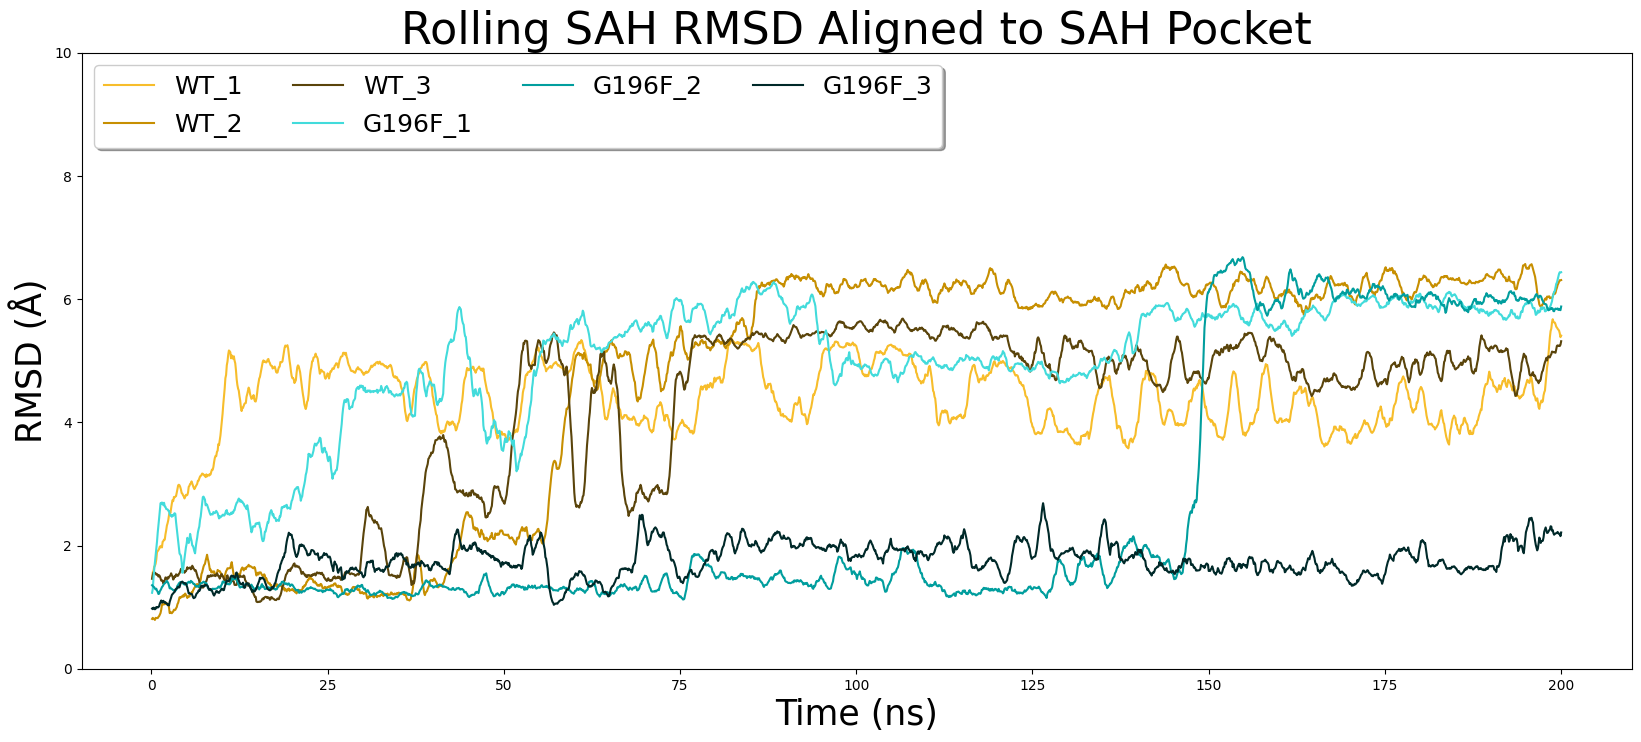

In [10]:
# Colors
# decide what to graph
ci = 0
all = True # if all run types on one graph - true, else false
run_type_graph = "" # if just one run type, put the name of it here
fig, ax = plt.subplots(figsize=(20, 8))
averaged = 10

titleSize = 32 
labelSize = 25
legendSize = 18

if all:
    colors = ["#F7BD2B", "#C78F01", "#5A440B", "#42DBDB", "#019E9E", "#002929"]
    toGraph = allRMSDs # graph everything

else:
    colors = ["#D4A017", "#008080", "#708090", "#691751"] 
    toGraph = allRMSDs[run_type_graph] # graph just WT_v11fig, ax = plt.subplots(figsize=(20, 8))

# plot setting
#ax.rcParams.update({'font.size': 30})
if selection == []:
    ax.set_title('Rolling RMSD Aligned to FAD Pocket', fontsize=titleSize)
if isinstance(selection, str):
    ax.set_title(f'Rolling RMSD for {selection} Aligned to Pocket', fontsize=titleSize)
elif len(selection) >= 2:
    ax.set_title(f'Rolling RMSD for {selection[0]}-{selection[1]} Aligned to FAD Pocket', fontsize=titleSize)
else:
    ax.set_title(f'Rolling SAH RMSD Aligned to SAH Pocket', fontsize=titleSize)

ax.set_xlabel('Time (ns)', fontsize=labelSize)
ax.set_ylabel('RMSD (Å)', fontsize=labelSize)


# Plot the data with the specified colors
timesteps = np.linspace(0, sim_length, len(list(list(allRMSDs.values())[0].values())[0])+1)[1:]
for (run_name, run_type) in toGraph.items():

    # Plot the data with the specified colors
    if(isinstance(run_type, dict)):
        for (series, values) in run_type.items():
            new_values = rolling_average(values)
            ax.plot(timesteps, new_values, label=f"{run_name.split("_")[0]}_{series[-1]}", color=colors[ci])
            ci = ci + 1
    else:
        ax.plot(timesteps, run_type, label=f"{run_name.split("_")[0]}", color=colors[ci])
        ci = ci + 1

# Add legend
ax.legend(loc='upper left', shadow=True, ncol=4, fontsize=legendSize)

ax.set_ylim(bottom=0, top=10)
plt.style.context("seaborn-talk")

# Save the figure as a vectorized PDF or SVG for Adobe Illustrator
plt.savefig(f'Plots/{run_types[0].split("_")[0]}_{run_types[1].split("_")[0]}_all_runs_rmsd.png', format='png', bbox_inches='tight')  # For SVG format

#### Plots RMSD
*Requires allRMSDs which is calculated in section 2*

In [ ]:
# Colors
colors = ["#D4A017", "#008080", "#708090", "#691751"] # ! IF YOU WANT TO PUT COLORS, PUT HERE! SAME ORDER AS RUN_TYPE!
fig, ax = plt.subplots(figsize=(20, 8))

titleSize = 32 
labelSize = 25
legendSize = 18

# plot setting
#ax.rcParams.update({'font.size': 30})
if selection == []:
    ax.set_title('Average SAH RMSD using center structure', fontsize=titleSize)
if isinstance(selection, str):
    ax.set_title(f'Average RMSD for {selection} using center structure', fontsize=titleSize)
elif len(selection) >= 2:
    ax.set_title(f'Average RMSD for {selection[0]}-{selection[1]} using center structure', fontsize=titleSize)
else:
    ax.set_title(f'Average SAH RMSD Aligned to SAH Pocket', fontsize=titleSize)

ax.set_xlabel('Time (ns)', fontsize=labelSize)
ax.set_ylabel('RMSD (Å)', fontsize=labelSize)


# Plot the data with the specified colors
for (series, values), color in zip(allAveragedRMSDs.items(), colors):
    ax.plot(np.linspace(0, sim_length, len(values)+1)[1:], values, label=series.split("_")[0], color=color)

# Add legend
ax.legend(loc='upper right', shadow=True, ncol=4, fontsize=legendSize)
plt.style.context("seaborn-talk")

ax.set_ylim(bottom=0, top=8)
plt.savefig(f'Plots/{run_types[0].split("_")[0]}_{run_types[1].split("_")[0]}_rmsd.png', format='png', bbox_inches='tight')  # For SVG format

#### Plots Average (between runs) Distance Between an RPIs For Each Miliseccond of Every Simulation
*Requires either allHDistances or allDDistances, calculated in section 1*

*Make sure to select which list to create a graph of, depending if looking at H-bonds or default distances*

In [ ]:
def extract_distances(run_list):
    # If elements are tuples, extract the first element (distance); otherwise, return the list as is
    return [x[0] if isinstance(x, tuple) else x for x in run_list]

colors = ["#D4A017", "#008080", "#708090"]
name = rpiH_strs[0].split("_")[0].split(".")[0] + "_" + rpiH_strs[0].split("_")[1].split(".")[0]

# SELECT EITHER HDistance or DDistance. Can't do both at once.
rpi_strs = rpiH_strs
allDistance = allHDistance

plt.figure(figsize=(12, 6))
for run_type, color in zip(run_types, colors):
    average_list = []
    final_y = []
    for rpi in rpi_strs:
        
        temp = []
        # gets the distance for each frame from each run. Creates a list of all of the distances of all the runs
        for run in run_count:
            temp.append(extract_distances(allDistance[run_type][run][rpi]))
        
        zipped_lists = np.swapaxes(temp,0, 1) # inverts the list so each frames distances are all together in an index
        average_list.append([np.nanmean(i) for i in zipped_lists]) # finds average of each index. AKA finds average disstance each frame
    
    # find minimum for each
    average_list2 = np.swapaxes(average_list,0, 1)
    print(average_list2[1])
    final_y = [np.min(i) for i in average_list2]
    
    plt.plot(np.linspace(0, sim_length, len(final_y)+1)[1:], final_y, label=f'{run_type}', color = color)

plt.title(f'Residues {name} - Average Distance Over Time', fontsize=14)
plt.xlabel('Time (nanoseconds)', fontsize=12)
plt.ylabel('Average Distance (Å)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
#plt.xlim(0, 5)
plt.grid(True)
plt.savefig(f'Plots/{run_types[0].split("_")[0]}_{run_types[1].split("_")[0]}_dist_{gen_rpi_name}.png', format='png')
plt.show()

#### Statistics About Each RPI in Each Run Type
*Requires allHDistances from section 1. allDDistances does NOT work (doesnt have angle data)*

In [ ]:
""" goes through each MD sim type and then goes through each residue of interest to find:
To find a variety of statistics that depend on the distance and angle b/w the residues
Allows for finding the % of the time there is an H bond present """

words = ""
with open(f"Plots/{run_types[0].split("_")[0]}_{run_types[1].split("_")[0]}_stats_{gen_rpi_name}.txt", "w") as f:
    for run_type in run_types: # for each MD sim type
        words = words + f"Variant: {run_type}\n"
        print()
        
        run_type_percents = [] # holds % of the time each run is H-bound
        run_type_min_distances = [] # holds every frames min frame across all runs
        
        for run in run_count: # for each run
            
            run_min_distances = [] # each frames lowest bound (if found) distance
            run_if_bound = [] # if each frame is bound. If 1, it is bound, if 0 it is not bound for any RPI
            
            for frame in range(len(allHDistance[run_type][run][rpi])): # for each frame
                frame_distances = [] # finds 
                frame_bound_distances = []
                frame_bound = False
                for rpi in rpiH_strs: # for each residue of interest
                
                    # extract distance and angle for this rpi / frame
                    distance = allHDistance[run_type][run][rpi][frame][0]
                    angle = allHDistance[run_type][run][rpi][frame][1]
                    frame_distances.append(distance)

                    # if this RPI is H-bound
                    if(distance < 3.5 and angle > 120):
                        frame_bound = True
                        frame_bound_distances.append(distance)
                
                # if there was one RPI that was H-bound, set frame to true
                if(frame_bound):
                    run_if_bound.append(1)
                else:
                    run_if_bound.append(0)

                # find lowest distance for this frame
                if(frame_bound):
                    run_min_distances.append(np.min(frame_bound_distances))
                else:
                    run_min_distances.append(np.min(frame_distances))
            

            # Calculate the overall average
            run_lowest_distance_avg = np.nanmean(run_min_distances)
            run_lowest_distance_std = np.nanstd(run_min_distances)  # Make sure to use np.std
                    
            # Get the lowest overall distance
            run_lowest_distance_min = np.nanmin(run_min_distances)
            
            # Calculate the percentage of frames where H-bond is present
            run_h_bond_percent = (np.nanmean(run_if_bound)) * 100

            # save data for this run_type
            run_type_percents.append(run_h_bond_percent)
            run_type_min_distances.extend(run_min_distances)

            
            # Print the results 
            words = words + f"{run}\n"
            words = words +  f"  Average Min Distance: {round(run_lowest_distance_avg, 6)}\n"
            words = words + f"  Std Min Distance: {round(run_lowest_distance_std, 6)}\n"
            words = words + f"  Overall Lowest distance: {round(run_lowest_distance_min, 6)}\n"
            words = words + f"  H-bond %: {round(run_h_bond_percent, 6)}%\n"
            words = words + f""
            
        #print total results
        overall_average = round(np.nanmean(run_type_min_distances), 6)
        overall_std = round(np.nanstd(run_type_min_distances), 6)  # Make sure to use np.std
        overall_bond = round(np.nanmean(run_type_percents), 2)
        words = words + f" Overall average: {overall_average}\n"
        words = words + f" Overall std: {overall_std}\n"
        words = words + f" Overall H-bond %: {overall_bond}%\n\n\n"

        words = words + "\n\n"
    print(words)
    f.write(words)

#### Find Distance Between Pocket and Ligand
*Needs output from VMD distances script*

In [ ]:
# import the VMD distance's found
pocket_distances = {}
for run_type in run_types:
    pocket_distances[run_type] = []
    for run in range(len(run_count)): 
        pocket_distances[run_type].append([])
        with open(f"data_storage/WT_S440W/FAD_pocket_distance/posedistance_{run_type.split("_")[0]}{run+1}.dat", "r") as f:
            text = f.read()
            text = text.split("\n")
            for line in text:
                split_line = line.split("	")
                if len(split_line) > 1:
                    pocket_distances[run_type][-1].append(float(line.split("	")[1]))


    # average it all together
    pocket_distances[run_type] = np.swapaxes(pocket_distances[run_type],0, 1)
    pocket_distances[run_type] = [np.nanmean(i) for i in pocket_distances[run_type]]

# graph
colors = ["#D4A017", "#008080", "#708090", "#691751"] # ! IF YOU WANT TO PUT COLORS, PUT HERE! SAME ORDER AS RUN_TYPE!
fig, ax = plt.subplots(figsize=(20, 8))

titleSize = 32 
labelSize = 25
legendSize = 18

ax.set_title('Average Distance Between FAD and Pocket CoM',fontsize=titleSize)

ax.set_xlabel('Time (ns)',fontsize=labelSize)
ax.set_ylabel('Distance (Å)',fontsize=labelSize)

# Plot the data with the specified colors
for (series, values), color in zip(pocket_distances.items(), colors):
    ax.plot(np.linspace(0, sim_length, len(values)+1)[1:], values, label=series.split("_")[0], color=color)

# Add legend
ax.legend(loc='upper right', shadow=True, ncol=4,fontsize=legendSize)

# Adjust x-ticks for 640 residues, spaced by 50
ax.set_ylim(bottom=6, top=18)

# Save the figure as a vectorized PDF or SVG for Adobe Illustrator
plt.style.context("seaborn-talk")

# Save the figure as a vectorized PDF or SVG for Adobe Illustrator
plt.savefig(f'Plots/{run_types[0].split("_")[0]}_{run_types[1].split("_")[0]}_SAH_pocket_distance.png', format='png', bbox_inches='tight')  # For SVG format

#### Find Pocket Distance, Each Run Seperate

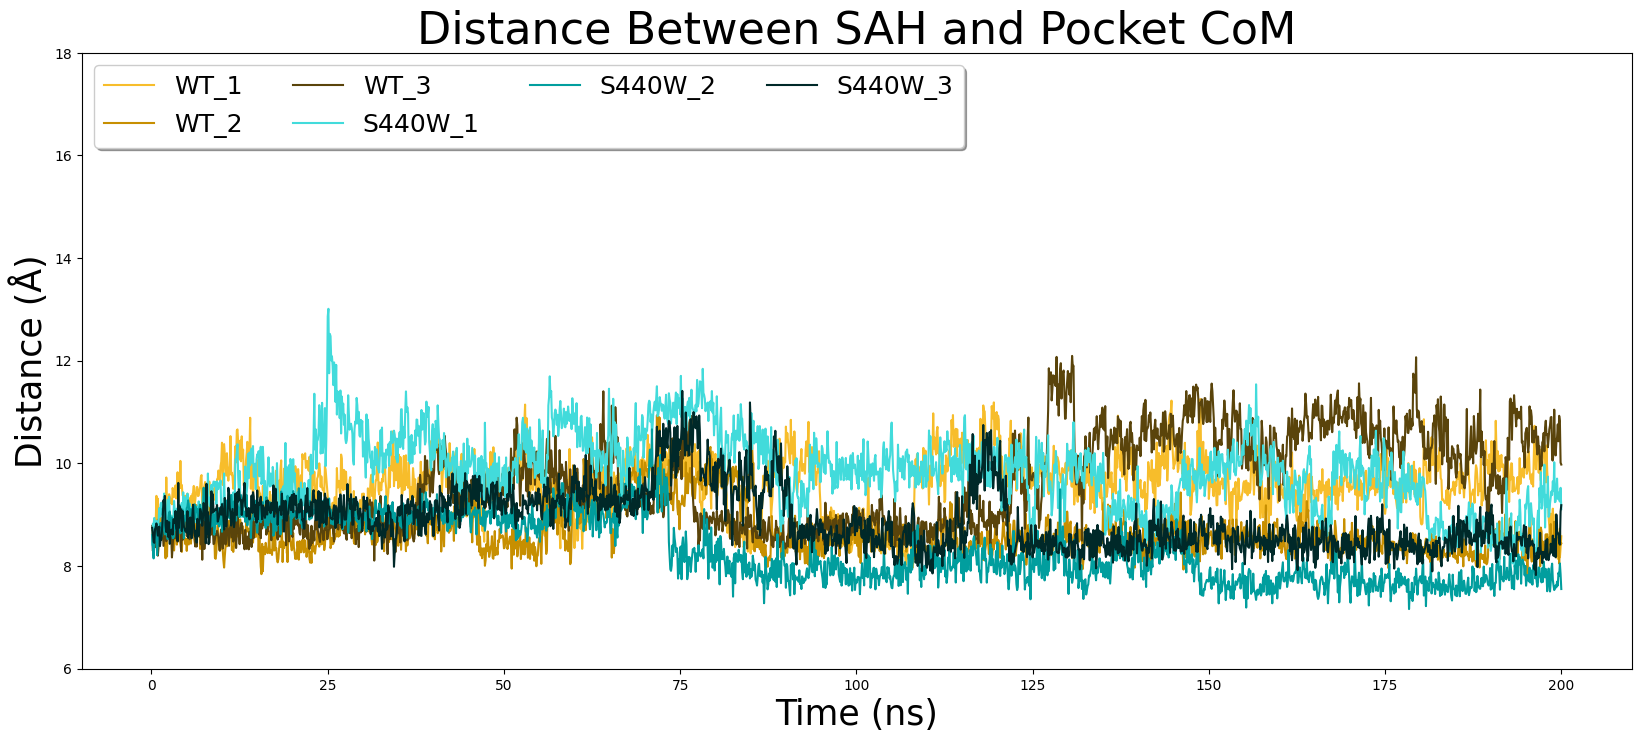

In [16]:
# import the VMD distance's found
pocket_distances = {}
for run_type in run_types:
    for run in range(len(run_count)): 
        pocket_distances[f"{run_type.split("_")[0]}_{str(run+1)}"] = []
        with open(f"data_storage/WT_S440W/SAH_pocket_distance/posedistance_{run_type.split("_")[0]}{run+1}.dat", "r") as f:
            text = f.read()
            text = text.split("\n")
            for line in text:
                split_line = line.split("	")
                if len(split_line) > 1:
                    pocket_distances[f"{run_type.split("_")[0]}_{str(run+1)}"].append(float(line.split("	")[1]))

ci = 0
all = True # if all run types on one graph - true, else false
run_type_graph = "" # if just one run type, put the name of it here
fig, ax = plt.subplots(figsize=(20, 8))

titleSize = 32 
labelSize = 25
legendSize = 18

if all:
    colors = ["#F7BD2B", "#C78F01", "#5A440B", "#42DBDB", "#019E9E", "#002929"]
else:
    colors = ["#D4A017", "#008080", "#708090", "#691751"] 
    remove = []
    for key in pocket_distances.keys(): # graph just WT_v11fig, ax = plt.subplots(figsize=(20, 8))
        if not key.startswith(run_type_graph):
            remove.append(key)
    for key in remove:
        del pocket_distances[key]
    

ax.set_title('Distance Between SAH and Pocket CoM',fontsize=titleSize)

ax.set_xlabel('Time (ns)',fontsize=labelSize)
ax.set_ylabel('Distance (Å)',fontsize=labelSize)

# Plot the data with the specified colors
for (series, values), color in zip(pocket_distances.items(), colors):
    ax.plot(np.linspace(0, sim_length, len(values)+1)[1:], values, label=f"{series.split("_")[0]}_{series[-1]}", color=color)

# Add legend
ax.legend(loc='upper left', shadow=True, ncol=4,fontsize=legendSize)

# Adjust x-ticks for 640 residues, spaced by 50
ax.set_ylim(bottom=6, top=18)

# Save the figure as a vectorized PDF or SVG for Adobe Illustrator
plt.style.context("seaborn-talk")

# Save the figure as a vectorized PDF or SVG for Adobe Illustrator
plt.savefig(f'Plots/{run_types[0].split("_")[0]}_{run_types[1].split("_")[0]}_all_run_FAD_pocket_distance.png', format='png', bbox_inches='tight')  # For SVG format